On importe les librairies :

In [0]:
!pip install TensorFlow == 2.0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

ERROR: Could not find a version that satisfies the requirement 2.0 (from versions: none)
ERROR: No matching distribution found for 2.0


On charge le Dataset dans le DataFrame DF et on affich les 5 premières lignes :

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_0.csv', sep = ',')
df.head()

,GOLD_Time,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market_Cap,BCH_Open,BCH_High,BCH_Low,...,ICE_Low,ICE_Close,ICE_Volume,IEF_Open,IEF_High,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,Day_Cos,Day_Sin
0,2019-12-31,1523.0,1523.0,1157.78,1157.78,1358.06,1358.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,230.50,235.675,230.20,235.30,5766007.0,45.86,46.09,44.927,45.86,31562358.0,1330.11,1338.00,1329.085,1337.02,961438.0,17.76,17.860,17.58,17.69,0.0,NaN,NaN,NaN,NaN,0.0,132.55,134.110,132.44,133.98,0.0,-0.222521,9.749279e-01
1,2019-12-30,1511.5,1515.0,1152.37,1152.57,1350.22,1351.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,235.84,236.200,231.09,232.32,6263092.0,45.52,46.17,44.660,45.52,40899781.0,1350.00,1353.00,1334.020,1336.14,1047066.0,17.81,18.070,17.62,17.81,0.0,NaN,NaN,NaN,NaN,0.0,135.25,135.278,132.50,132.78,0.0,0.623490,7.818315e-01
2,2019-12-29,1510.6,1511.5,1156.36,1152.67,1356.37,1353.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.000000,-2.449294e-16
3,2019-12-28,1510.6,1511.5,1156.36,1152.67,1356.37,1353.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.623490,-7.818315e-01
4,2019-12-27,1510.6,1511.5,1156.36,1152.67,1356.37,1353.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,239.61,240.340,235.81,236.87,6320454.0,46.85,46.88,45.975,46.18,36324219.0,1362.99,1364.24,1349.310,1351.89,1030643.0,17.99,18.039,17.69,17.84,0.0,NaN,NaN,NaN,NaN,0.0,135.00,135.750,134.87,135.26,0.0,-0.222521,-9.749279e-01


On remplace les valeurs manquantes 'NaN' par des zéros. Il fallait supprimer les dernières lignes pour lesquelles on n'a pas de valeurs enregistrées, il fallait prendre fin Novembre 2019 comme limite de notre dataset, mais on continue quand même pour tester le comportement du système.

In [0]:
df = df.set_index('GOLD_Time')
for col in df.columns:
  for i in range(len(df)):
    if np.isnan(pd.to_numeric(df[col][i])):
      df[col][i] = 0

df.head()

,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market_Cap,BCH_Open,BCH_High,BCH_Low,BCH_Close,...,ICE_Low,ICE_Close,ICE_Volume,IEF_Open,IEF_High,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,Day_Cos,Day_Sin
GOLD_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,1523.0,1523.0,1157.78,1157.78,1358.06,1358.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.50,235.675,230.20,235.30,5766007.0,45.86,46.09,44.927,45.86,31562358.0,1330.11,1338.00,1329.085,1337.02,961438.0,17.76,17.860,17.58,17.69,0.0,0.0,0.0,0.0,0.0,0.0,132.55,134.110,132.44,133.98,0.0,-0.222521,9.749279e-01
2019-12-30,1511.5,1515.0,1152.37,1152.57,1350.22,1351.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235.84,236.200,231.09,232.32,6263092.0,45.52,46.17,44.660,45.52,40899781.0,1350.00,1353.00,1334.020,1336.14,1047066.0,17.81,18.070,17.62,17.81,0.0,0.0,0.0,0.0,0.0,0.0,135.25,135.278,132.50,132.78,0.0,0.623490,7.818315e-01
2019-12-29,1510.6,1511.5,1156.36,1152.67,1356.37,1353.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00,0.00,0.0,0.00,0.00,0.000,0.00,0.0,0.00,0.00,0.000,0.00,0.0,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00,0.00,0.0,1.000000,-2.449294e-16
2019-12-28,1510.6,1511.5,1156.36,1152.67,1356.37,1353.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00,0.00,0.0,0.00,0.00,0.000,0.00,0.0,0.00,0.00,0.000,0.00,0.0,0.00,0.000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00,0.00,0.0,0.623490,-7.818315e-01
2019-12-27,1510.6,1511.5,1156.36,1152.67,1356.37,1353.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,239.61,240.340,235.81,236.87,6320454.0,46.85,46.88,45.975,46.18,36324219.0,1362.99,1364.24,1349.310,1351.89,1030643.0,17.99,18.039,17.69,17.84,0.0,0.0,0.0,0.0,0.0,0.0,135.00,135.750,134.87,135.26,0.0,-0.222521,-9.749279e-01


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2561 entries, 2019-12-31 to 2013-01-02
Columns: 150 entries, GOLD_USD_AM to Day_Sin
dtypes: float64(150)
memory usage: 3.0+ MB


On enregistre les max de chaque colonne dans un DataFrame qui va nous servir pour une sorte de normalisation des données. Ce n'est pas la meilleure façon de normaliser, mais on le fait quand même pour avancer et tester l'algorithme.

In [0]:
df_max = df.describe()[:][-1:]

On crée un dictionnaire qui contient des listes qui contient les valeurs de df divisées par la max de chaque colonne. On obtient alors des données (relativement) normalisées.

In [0]:
columns = df.columns
dictionnaire = {}
for i in columns:
  dictionnaire[i] = (np.array(df[i])/np.array(df_max[i])).reshape((len(df),1))

On constitue une liste Numpy Array qui contient les éléments du dictionnaire "dictionnaire". On a eu recours à cette approche (qui n'est pas forcément la meilleure haha) pour être sûr des types et des shapes des données.

In [0]:
horizontal_dataset = dictionnaire['BTC_Open']
i = 0
for col in columns:
  i += 1
  if i > 1:
    horizontal_dataset = np.hstack ((horizontal_dataset, dictionnaire[col]))
print(horizontal_dataset.shape)

(2561, 150)


On divise les données en test (les 400 derniers enregistrements) et train (le reste des enregistrements). Il faut faire attention à l'odre dans lequel les données sont enregistrées, le dernier élément enregistré correspond à la première date.

In [0]:
test_size = 400
train, test = horizontal_dataset[test_size:,:], horizontal_dataset[:test_size,:]
print(train.shape)

(2161, 150)


On définir la taille de l'échantillon (n_input) qui va être pris en compte pour estimer la valeur suivante. n_features correspon au nombre de paramètres de chaque enregistrement, ici cela correspond à 150 qui représente le nombre de colonnes.
On crée également un TimeseriesGenerator (c'est un itérateur) qui va créer pour chaque donnée une suite de n_input = 30 valeurs précédentes. Le batch_size est un paramètre qui va servir pour l'entrainement du réseau de neurones (The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.). Je n'ai pas une bonne maitrise de cet objet ni de ses paramètres...

In [0]:
n_input = 30
n_features = horizontal_dataset.shape[1]
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

On crée un réseau de neuronnes très simple constitué des couches suivantes :
- LSTM (Long Short Time Memory) avec 3750 noeuds de neurones (il faut qu'il soit assez grand pour intégrer les (2561 lignes * 150 colonnes * 30 enregistrements du batch). La fonction d'activation choisie est 'relu' : c'est l'unité de rectification linéaires f(x) = { 0 si x < 0 ; x si x >= 0 }
- Dropout : on supprime 15% des données avant l'entrainement pour éviter l'overfitting
- Dense : 150 correspond à la dimension de l'output

On compile avec :
- l'optimiseur 'adam' pour mettre à jour les paramètres du réseau de neurones lors de  la back propagation
- la fonction de perte 'mse' l'errer quadratique moyenne

Ces paramètres ont été choisis d'une façon assez arbitraire pour tester.

In [0]:
model = Sequential()
model.add(LSTM(3750, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(150))
model.compile(optimizer='adam', loss='mse')


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


On entraine le modèle avec :
- steps_per_epoch: Integer. Total number of steps (batches of samples) to yield from generator
- epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.

In [0]:
model.fit_generator(generator, steps_per_epoch=1, epochs=35, verbose=2)

Epoch 1/35
 - 17s - loss: 0.1585
Epoch 2/35
 - 11s - loss: 4.3778
Epoch 3/35
 - 11s - loss: 0.1252
Epoch 4/35
 - 11s - loss: 0.1409
Epoch 5/35
 - 11s - loss: 0.3425
Epoch 6/35
 - 11s - loss: 0.1447
Epoch 7/35
 - 11s - loss: 0.1370
Epoch 8/35
 - 11s - loss: 0.1046
Epoch 9/35
 - 11s - loss: 3680.2368
Epoch 10/35
 - 11s - loss: 0.1359
Epoch 11/35
 - 11s - loss: 0.1290
Epoch 12/35
 - 11s - loss: 0.1374
Epoch 13/35
 - 11s - loss: 0.1327
Epoch 14/35
 - 11s - loss: 0.1823
Epoch 15/35
 - 11s - loss: 0.1510
Epoch 16/35
 - 11s - loss: 0.1501
Epoch 17/35
 - 11s - loss: 0.1616
Epoch 18/35
 - 11s - loss: 0.1413
Epoch 19/35
 - 11s - loss: 0.1449
Epoch 20/35
 - 11s - loss: 0.1354
Epoch 21/35
 - 11s - loss: 49863.3320
Epoch 22/35
 - 6s - loss: 0.1411
Epoch 23/35
 - 11s - loss: 0.1247
Epoch 24/35
 - 11s - loss: 0.1532
Epoch 25/35
 - 11s - loss: 0.2595
Epoch 26/35
 - 11s - loss: 0.1780
Epoch 27/35
 - 11s - loss: 0.1352
Epoch 28/35
 - 11s - loss: 0.3278
Epoch 29/35
 - 11s - loss: 0.1455
Epoch 30/35
 - 11

On crée un liste pred_list pour enregistrer chaque prédiction. Le batch corrspond à l'input de notre modèle. On itèle sur le nombre de lignes du test. A chaque itératon, on prédit la nouvelle valeur (de dimension 150), on l'ajoute à la liste pred_list, et on met à jour le batch avec les vraies valeurs suivantes de "test".

In [0]:
pred_list = []
batch = train[:n_input,:].reshape((1, n_input, n_features))
for i in range(400):
  pred_list.append(model.predict(batch)[0]*np.array(df_max).reshape(150,))
  batch = np.append(batch[:, :-1,:], [[test[i]]], axis=1)

On transforme la liste pred_list en DataFrame en définissant les mêmes indices et noms de colonnes que df.

In [0]:
df_predict = pd.DataFrame(pred_list, 
                          index=df[:400].index, 
                          columns=df.columns)
df_predict.head()

,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market_Cap,BCH_Open,BCH_High,BCH_Low,BCH_Close,...,ICE_Low,ICE_Close,ICE_Volume,IEF_Open,IEF_High,IEF_Low,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,Day_Cos,Day_Sin
GOLD_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,1583.214250,3137.910781,4197.610578,2188.179003,5005.339853,5778.699026,-27573.045796,10134.365895,39384.916211,-11503.103981,1.805348e+10,-2.363571e+11,3.362955,2.109791,4.502039,0.069753,1.000286e+09,5.289737e+10,713.329684,84.020454,-367.190642,388.739323,1.283636e+10,1.553477e+10,35.581916,12.058696,3.879039,18.180120,1.381245e+10,1.001208e+10,513.739948,3087.169594,837.292027,1911.139917,4.710882e+10,-6.785443e+10,3090.618037,6103.264038,-263.675023,3867.279012,...,-40.189298,123.465226,-5.891116,-35.674487,274.934989,65.998079,121.243034,-92.820208,-315.452277,-128.607213,217.362280,-534.109358,-6.174176e+07,-195.954132,40.380769,102.026622,35.263299,-1.952651e+08,2504.294215,-1012.014340,3747.451804,4558.859461,8.233275e+06,165.880281,295.369455,106.430540,37.748991,3.225373e+07,-7244.714001,3407.772818,-1149.605671,6070.071644,125.705899,46.125546,635.660046,448.994215,157.337822,3.768544e+07,-0.254242,-0.477106
2019-12-30,1360.526306,3027.535133,4123.311737,2138.874700,4501.700114,5556.069126,-28787.811866,13873.364771,38953.449591,-11053.572424,1.912073e+10,-2.491563e+11,3.123794,1.963672,4.291547,-0.057717,8.754378e+08,4.578842e+10,661.763458,28.694801,-366.392783,402.969875,1.288160e+10,1.651505e+10,35.534200,11.776773,3.285590,15.838650,1.282927e+10,4.108550e+09,261.691382,2719.660492,703.453386,1568.089961,4.923232e+10,-8.764122e+10,2669.215928,5251.524535,-438.654834,3053.864074,...,-67.505074,112.810146,-17.019320,-49.187345,262.704642,64.915631,113.594219,127.496799,-316.725944,-157.001425,185.948155,-601.660777,-6.638657e+07,-161.571944,35.238979,110.398409,29.602051,-2.076801e+08,2182.229373,-1007.220752,3551.300170,4325.943288,4.166552e+06,161.349370,276.410011,106.761178,36.759559,2.547244e+07,-7419.045662,3650.899349,-2037.646095,5478.494588,105.754820,31.785818,625.695908,362.809907,159.039774,3.202113e+07,-0.327840,-0.447350
2019-12-29,1344.216796,3019.753960,4130.740037,2140.113565,4493.187444,5550.180638,-28672.145066,14028.488841,39041.282801,-11115.050460,1.952502e+10,-2.508221e+11,3.116471,1.967520,4.306767,-0.054621,8.785879e+08,4.570062e+10,661.159814,28.049737,-367.996103,402.858980,1.286010e+10,1.648728e+10,35.486620,11.804471,3.185191,15.898259,1.285766e+10,4.128601e+09,272.525528,2717.220225,694.985492,1561.445130,4.921032e+10,-8.728415e+10,2643.553907,5289.482140,-472.542620,3036.722069,...,-67.149090,112.553276,-17.078147,-50.608318,263.129993,65.032248,113.113593,117.647009,-317.836717,-154.958273,184.664287,-599.561654,-6.663058e+07,-162.695813,35.534448,110.225759,29.635381,-2.056858e+08,2178.200404,-1000.693456,3560.329382,4328.892276,4.234383e+06,161.376607,276.711199,106.716091,36.652101,2.553728e+07,-7429.534049,3646.797402,-2016.081933,5465.648843,105.849616,32.563029,626.931658,362.708783,160.828163,3.180832e+07,-0.325608,-0.465317
2019-12-28,1310.349578,2971.892235,4088.361737,2099.512082,4336.045441,5486.564349,-29128.344288,14235.771556,39260.137501,-11099.604832,2.083031e+10,-2.529113e+11,3.113496,1.904924,4.215653,-0.069407,8.214091e+08,4.390179e+10,643.80

In [0]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 2019-12-31 to 2018-11-27
Columns: 150 entries, GOLD_USD_AM to Day_Sin
dtypes: float64(150)
memory usage: 491.9+ KB


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2561 entries, 2019-12-31 to 2013-01-02
Columns: 150 entries, GOLD_USD_AM to Day_Sin
dtypes: float64(150)
memory usage: 3.0+ MB


On affiche le résultat pour la colonne 'LTC_High'. Les prédictions ne sont pas du tout précises, et on constate que l'affichage est inversé sur l'axe des x (la courbe devrais être la symétrique de celle obtenue par symétrie axiale d'axe y).

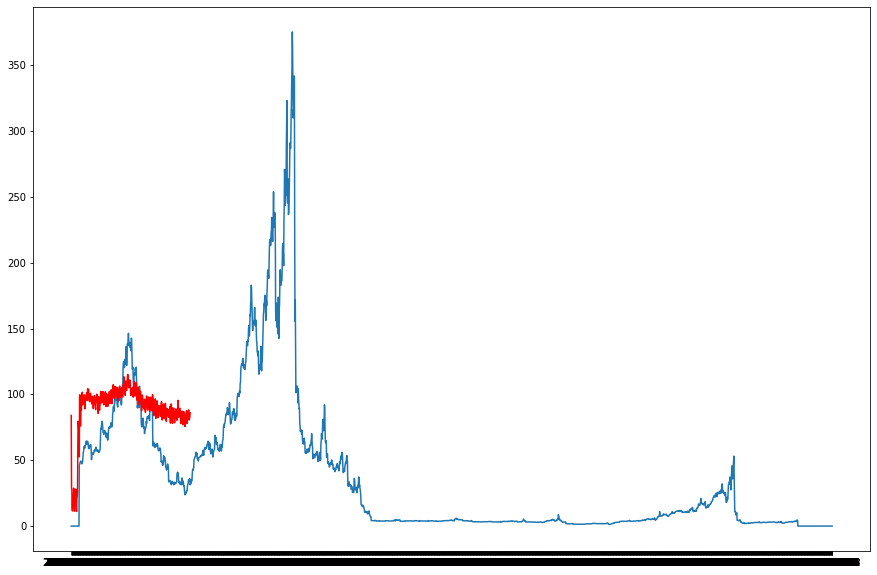

In [0]:
plt.figure(figsize=(15, 10))
plt.plot(df.index, df['LTC_High'])
plt.plot(df_predict.index, df_predict['LTC_High'], color='r')
plt.show()